#Assignment 3
Re-implement the example in section 7.10.2 using any simple, out of the box classifier (like K nearest neighbors from sci-kit). Reproduce the results for the incorrect and correct way of doing cross-validation.

## Analysis 7.10.2 Wrong and Right way of cross validation

Wrong way:
1. Screen the predictors: find a subset of “good” predictors that show
fairly strong (univariate) correlation with the class labels
2. Using just this subset of predictors, build a multivariate classifier.
3. Use cross-validation to estimate the unknown tuning parameters and
to estimate the prediction error of the final model

The problem is that the predictors have an unfair advantage, as they were chosen in step (1) on the basis of all of the samples. Leaving samples out after the variables have been selected does not correctly mimic the application of the classifier to a completely independent test set, since these predictors “have already seen” the left out samples.
___

Right way: K-folds cross validation

1. Divide the samples into K cross-validation folds (groups) at random.
2. For each fold k = 1, 2, . . . , K

    a. Find a subset of “good” predictors that show fairly strong (univariate) correlation with the class labels, using all of the samples except those in fold k.

    b. Using just this subset of predictors, build a multivariate classifier, using all of the samples except those in fold k.
    
    c. Use the classifier to predict the class labels for the samples in fold k.

The error estimates from step 2(c) are then accumulated over all K folds, to
produce the cross-validation estimate of prediction error



## Generate random dataset
Dataframe contains 50 observations and 5000 features. Features generated using standard gaussian distribution. True error accuracy is 50%.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, [50,5000])
df = pd.DataFrame(s)
df['label'] = np.zeros([df.shape[0],1])
df['label'][0:round(df.shape[0]/2)] = 1  # 50% correct
# display(df.head())

## Wrong Way of Cross Validation
1. Screen the predictors: find a subset of “good” predictors that show
fairly strong (univariate) correlation with the class labels
2. Using just this subset of predictors, build a multivariate classifier.
3. Use cross-validation to estimate the unknown tuning parameters and
to estimate the prediction error of the final model

Incorrect Cross Validation Error Rate is 3.0%.


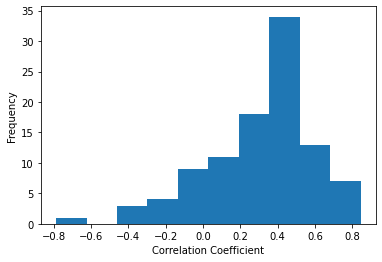

In [ ]:
def generate_df(): 
  mu, sigma = 0, 1 # mean and standard deviation
  s = np.random.normal(mu, sigma, [50,5000])
  df = pd.DataFrame(s)
  df['label'] = np.zeros([df.shape[0],1])
  df['label'][0:round(df.shape[0]/2)] = 1  # 50% correct
  # display(df.head())
  return df

def select_feature(df,num_feat,plot = False):
  local_df = df.copy()
  # Feature correlation using Pearson Correlation
  correlation = []
  correlation_abs = []
  for features in df.columns[:-1]:
    correlation.append(df[features].corr(df['label']))
    correlation_abs.append(abs(df[features].corr(df['label'])))
  local_df = local_df.append(pd.Series(correlation,name="correlation"),ignore_index = False)
  local_df = local_df.append(pd.Series(correlation_abs,name="correlation abs"),ignore_index = False)
  local_df = local_df.sort_values(by=("correlation"),axis = 1, ascending=False)
  local_df = local_df[local_df.columns[0:num_feat]]
  correlation = local_df.loc['correlation',:]
  correlation_abs = local_df.loc['correlation abs',:]
  local_df = local_df.drop(["correlation", "correlation abs"],axis=0)

  # if(plot == True):
  #   plt.figure()
  #   plt.hist(correlation)
  #   plt.xlabel("Correlations of Selected Predictors")
  #   plt.ylabel("Frequency")
  #   plt.title("Wrong way")
  return local_df

def classify(features,labels):
  neigh = KNeighborsClassifier(n_neighbors=1,metric='euclidean')
  neigh.fit(features, labels)
  return neigh

def cross_validation(features,labels,clf):
  pred = clf.predict(features)
  score = accuracy_score(labels,pred,normalize=True)
  print(score)
  return score

def wrong_cross_validation(plot=False, print_output=False):
  df = generate_df()
  df = df.sample(frac=1,random_state=1).reset_index(drop=True)
  # Select 100 features
  features = select_feature(df,100,plot=False)
  labels = df['label']
  selected_feats = features.columns
  # Create classifier object, perform cross validation, and reprot score
  neigh = KNeighborsClassifier(n_neighbors=1,metric='euclidean')
  score = cross_val_score(neigh,X=features,y=labels,cv = 5)
  score = sum(score)/score.shape[0]

  if(print_output == True):
    print(f"CV score = {round(score,3)}")

  # Plotting correaltion histogram using randomly selected 10 samples
  if(plot == True):
    sample_df = df.copy()
    selected_feats = selected_feats.append(pd.Index(["label"]))
    sample_df = df.sample(frac=0.2,random_state=2).loc[:][selected_feats]    
    sample_corr = []
    for features in sample_df.columns[:-1]:
      sample_corr.append(sample_df[features].corr(sample_df['label']))

    plt.figure()
    plt.hist(sample_corr)
    plt.xlabel("Correlation Coefficient")
    plt.ylabel("Frequency")
    plt.show()
  return score


# Run CV 50 times, find average error rate
error_rate = 0
num_cycle = 50
for i in range(num_cycle):
  error_rate += (1- wrong_cross_validation(plot=False))
print(f"Incorrect Cross Validation Error Rate is {round(error_rate/num_cycle*100)}%.")

# Gnerate a correlation histogram
_ = wrong_cross_validation(plot=True)

## Right Way of Cross Validation Using K folds
1. Divide the samples into K folds at random
2. For each fold k in K, use the other folds to determine 
good predictors based on highest correlation to create a classifier
3. Use this classifier on fold k, and repeat the process

In this example, we used K Nearest Neighbors with n = 1.
Our random state of 2 resulted in 50% correct accuracy/50% 
error rate.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def score(test_feat,test_label,print_output = False):
  """
  Accuracy of validation label to predicted validation label
  Inputs are numpy arrays 
  """
  num_correct = 0
  for i in range(len(test_label)):
    if(test_feat[i] == test_label[i]):
      num_correct += 1
  accuracy = num_correct/len(test_label)
  if(print_output == True):
    print(f"Accuracy of current model is {round(accuracy,2)}\n")
  return accuracy


def right_cross_validation(df,k):
  """
  df is an input dataframe, and k is the number of folds
  returns the predicted error
  """
  df_split = np.array_split(df, k)
  error = [None]*k
  for i in range(len(df_split)):
    train = df_split[0:i] + df_split[i+1:len(df_split)] #excludes the validation and creates a list of numpy arrays
    train = pd.concat(train) #combines the list into 1 dataframe
    y_train = train["label"]
    x_train = train.drop(["label"], axis=1)

    validation = df_split[i] #pops the validation array
    validation = pd.DataFrame(validation) #converts the validation array into a dataframe 
    y_validation = validation["label"]
    x_validation = validation.drop(["label"], axis=1)

    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_validation)

    error[i] = score(y_pred,y_validation.to_numpy())

  return(np.mean(error)) #average of errors for each fold

In [ ]:
correct_df = df
correct_df = correct_df.sample(frac = 1, random_state =2)
success = right_cross_validation(correct_df,5)
error = 1-success

print(f"Correct Cross Validation Error Rate is {round(error,5)*100}%.")

Correct Cross Validation Error Rate is 38.0%.
